# Creating synthetic porphyry model and DC-IP data

**Author**: Seogi Kang

This notebook shows how we generated the 3D syntehtic porphyry model. 
By using the synthetic porphyry model, we run 3D DC and IP simulation to generate synthetic 
DC and IP data. 
Figures 3 and 4 in Kang and Oldenburg (2019) were generated using this notebook. 

## Create the synthetic porphyry model

In [38]:
from SimPEG import DC, SIP
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
from matplotlib import colors
from pylab import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 14
%matplotlib inline

In [26]:
fig_dir = "./figures/"

In [10]:
IO, survey = DC.Utils.gen_3d_survey_from_2d_lines(
    'dipole-dipole', 50, 50, 10, x0=-500, y0=-400,
    line_length=1000., line_spacing=200., n_lines=5 
)
mesh, actind = IO.set_mesh(dx=12.5, dz=10., dy=25, dimension=3)
# topo, mesh2d = DC.Utils.genTopography(mesh, 0., 200)
# mesh, actind = IO.set_mesh(topo=np.c_[mesh2d.gridCC[:,0], mesh2d.gridCC[:,1], Utils.mkvc(topo)], dx=25., dz=15., dy=50, dimension=3)
core_inds, mesh_core = Utils.ExtractCoreMesh(IO.xyzlim, mesh)

In [11]:
print (mesh)


  TensorMesh: 130,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    100       -823.22        823.22     12.50     78.44    1.30
   y     52     -1,058.94      1,033.94     25.00    156.87    1.30
   z     25       -408.58          0.00     10.00     62.75    1.30




In [27]:
def Circle2D(xc, r, n):
    theta = np.linspace(-np.pi, np.pi, n)
    x = r*np.cos(Utils.mkvc(theta))+xc[0]
    y = r*np.sin(Utils.mkvc(theta))+xc[1]

    return np.c_[x, y]

In [28]:
# airind = mesh.gridCC[:,2] > 0.
x0 = np.r_[-450, -450, 0.] 
x1 = np.r_[450, -450, 0.]
x2 = np.r_[450, 450, 0.]
x3 = np.r_[-450, 450, 0.]
pts0 = np.vstack((x0, x1, x2, x3, x0))
x0 = np.r_[-250, -250, -600.]
x1 = np.r_[250, -250, -600.]
x2 = np.r_[250, 250, -600.]
x3 = np.r_[-250, 250, -600.]
pts1 = np.vstack((x0, x1, x2, x3, x0))
pts = np.vstack((pts0, pts1))
inds_porphyry = Utils.ModelBuilder.PolygonInd(mesh, pts)
inds_overburden = np.logical_and(mesh.gridCC[:,2]<0., mesh.gridCC[:,2]>-30.)
np.random.seed(10)
x = np.random.randint(-500, 500, size=(100))
y = np.random.randint(-500, 500, size=(100))
z = np.random.randint(-40, 0, size=(100))

def get_random_blocks(xyz, mesh, dx=50, dy=50, dz=30):
    inds = []
    for i in range(xyz.shape[0]):
        p0 = np.r_[xyz[i,0]-dx/2., xyz[i,1]+dy/2., xyz[i,2]+dz/2.]
        p1 = np.r_[xyz[i,0]+dx/2., xyz[i,1]-dy/2., xyz[i,2]-dz/2.]
        inds.append(Utils.ModelBuilder.getIndicesBlock(p0, p1,mesh.gridCC))
    return np.hstack(inds)
    
inds_clay = get_random_blocks(np.c_[x, y, z], mesh)
inds_mineralization = Utils.ModelBuilder.getIndicesBlock(
    np.r_[100+100, 110, -50], np.r_[200+100, -100, -100.], mesh.gridCC
)
pts_0 = np.c_[Circle2D(np.r_[0, 0], 400, 20), np.zeros(20)]
pts_1 = np.c_[Circle2D(np.r_[0, 0], 150, 20), np.ones(20)*-600]
pts_halo = np.vstack((pts_0, pts_1))
inds_halo = Utils.ModelBuilder.PolygonInd(mesh, pts_halo)

pts_0 = np.c_[Circle2D(np.r_[0, 0], 250, 20), np.zeros(20)]
pts_1 = np.c_[Circle2D(np.r_[0, 0], 10, 20), np.ones(20)*-600]
pts_stock = np.vstack((pts_0, pts_1))
inds_stock = Utils.ModelBuilder.PolygonInd(mesh, pts_stock)
sig_background = 1./1000.
sig_overburden = 1./900.
sig_porphyry = 1./5000.
sig_stock = 1./4500.
sig_mineralization= 1./520.
sig_halo= 1./500.
sig_clay = 1./300.

sig_air = 1e-8
sigma = np.ones(mesh.nC)*sig_background
sigma[inds_porphyry] = sig_porphyry
sigma[inds_halo] = sig_halo
sigma[inds_stock] = sig_stock
sigma[inds_overburden] = sig_overburden
sigma[inds_clay] = sig_clay
sigma[inds_mineralization] = sig_mineralization
sigma[~actind] = 1e-8
sig = [sig_background, sig_overburden, sig_porphyry, sig_stock, sig_halo, sig_clay, sig_mineralization]

In [29]:
geo = np.ones(mesh.nC) * np.nan
for i, sig_temp in enumerate(sig):
    geo[sigma==sig_temp] = i

In [30]:
["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"]

['background',
 'overburden',
 'porphyry',
 'stock',
 'halo',
 'clay',
 'mineralization']

In [31]:
eta = np.zeros(mesh.nC) + 1e-2
eta[geo==4] = 0.1
eta[geo==5] = 0.1
eta[geo==6] = 0.1
tau = np.ones(mesh.nC) *0.1
tau[geo==4] = 0.5
tau[geo==5] = 0.5
tau[geo==6] = 5.
c = np.ones(mesh.nC)
c[geo==4] = 0.5
c[geo==5] = 0.8
c[geo==6] = 0.5

### Extract 2D slice and save them to be used in  XXX

In [39]:
indy = np.argwhere(mesh.vectorCCy==0)[0][0]

In [40]:
sigma_2d = Utils.mkvc(mesh.r(sigma, format='M')[:,indy,:])
eta_2d = Utils.mkvc(mesh.r(eta, format='M')[:,indy,:])
tau_2d = Utils.mkvc(mesh.r(tau, format='M')[:,indy,:])
c_2d = Utils.mkvc(mesh.r(c, format='M')[:,indy,:])

In [41]:
import h5py
def save_dict_to_hdf5(fname, dictionary):
    """
    Save a dictionary to hdf5
    """
    f = h5py.File(fname, "w")
    for key in dictionary.keys():
        dset = f.create_dataset(key, data=dictionary[key])
    f.close()

output_simulation = {
    'sigma_2d': sigma_2d,
    'eta_2d': eta_2d,
    'tau_2d': tau_2d,
    'c_2d': c_2d,
}
save_dict_to_hdf5('model_2d.h5', output_simulation)

### Plot all conductivity and all SE parameters

/Users/sgkang/anaconda3/lib/python3.7/site-packages/matplotlib/colorbar.py:600: UserWarning: set_ticks() must have been called.
  warnings.warn("set_ticks() must have been called.")


Text(0.5, 0, 'x (m)')

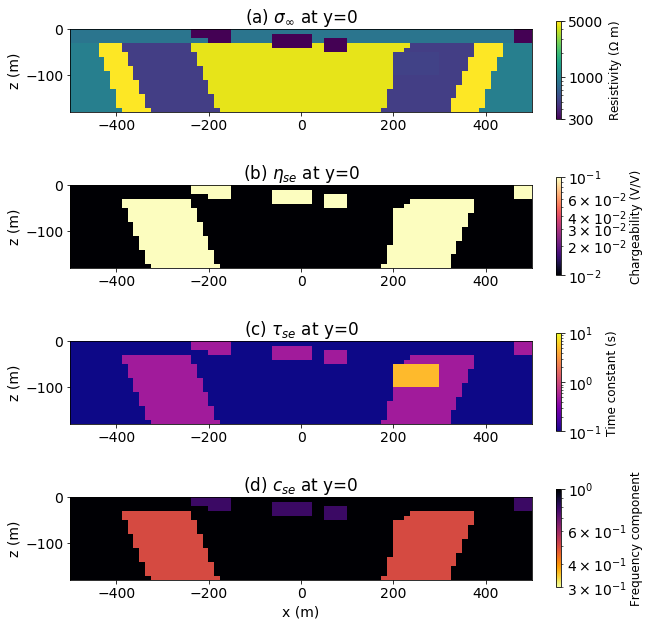

In [36]:
props = [1./sigma[core_inds], eta[core_inds], tau[core_inds], c[core_inds]]
cmaps = ['viridis', 'magma', 'plasma', 'inferno_r']
labels = [
    "Resistivity ($\Omega$ m)",
    "Chargeability (V/V)",
    "Time constant (s)",
    "Frequency component"    
]
titles = [
            '(a) $\sigma_{\infty}$', 
            '(b) $\eta_{se}$',
            '(c) $\\tau_{se}$',
            '(d) $c_{se}$',    
]
clims  = [(300, 5000), (0.01, 0.1), (0.1, 10.), (0.3, 1.)]
fig, axs = plt.subplots(4,1, figsize=(8*1.1, 10*1.1))
for i, value in enumerate(props):
    vmin, vmax = value.min(), value.max()
    out = mesh_core.plotSlice(
        value, grid=False, normal="Y", clim=clims[i], pcolorOpts={'norm':colors.LogNorm(), 'cmap':cmaps[i]},
        ax=axs[i]
    )
    axs[i].set_aspect("equal")
    cb = plt.colorbar(out[0], fraction=0.01, ax=axs[i])
#     cb.set_ticks([vmin, vmax])
    if i==0:
        cb.set_ticks([300,1000,5000])
        cb.set_ticklabels([300,1000,5000])
    else:
        cb.set_ticklabels(clims[i])
    if i<3:
        axs[i].set_xlabel("")
    axs[i].set_title(titles[i]+" at y=0")
    cb.set_label(labels[i], fontsize = 12)
    axs[i].set_ylabel("z (m)")
axs[-1].set_xlabel("x (m)")
# fig.savefig(fig_dir+"porphyry_se_models", dpi=200)

### Plot porphry model

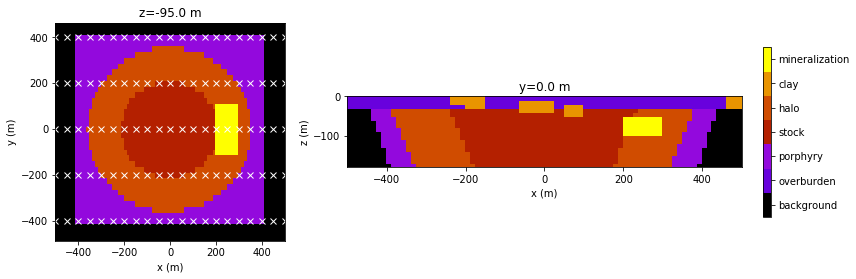

In [42]:

yc = 0
indy = int(np.argmin(abs(mesh_core.vectorCCy-yc)))
zc = -90
indz = int(np.argmin(abs(mesh_core.vectorCCz-zc)))

geomap = cm.get_cmap('gnuplot', len(sig))
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])

out = mesh_core.plotSlice(
    geo[core_inds], grid=False, normal="Y", clim=(0, 7), pcolorOpts={'cmap':geomap}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_core.vectorCCy[indy]))

out = mesh_core.plotSlice(
    geo[core_inds], grid=False, normal="Z", clim=(0, 7), ind=indz, pcolorOpts={'cmap':geomap}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_core.vectorCCz[indz]))
ax2.plot(IO.electrode_locations[:,0], IO.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cb=plt.colorbar(
    out[0], orientation="vertical", ticks=np.arange(len(sig))+0.5, ax=ax1, fraction=0.02
)
cb.set_ticklabels(["background", "overburden", "porphyry", "stock", "halo", "clay", "mineralization"])

for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
ax2.set_ylabel("y (m)")
ax2.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlabel("x (m)")
    
plt.tight_layout()
fig.savefig(fig_dir+"porphyry_model", dpi=200)

## Run DC simulation

In [44]:
m_true = np.log(sigma[actind])
actMap = Maps.InjectActiveCells(mesh, actind, np.log(1e-8))
mapping = Maps.ExpMap(mesh) * actMap
problem = DC.Problem3D_N(mesh, sigmaMap=mapping, storeJ=True)
problem.Solver = PardisoSolver
if survey.ispaired:
    survey.unpair()
problem.pair(survey)
dobs = survey.makeSyntheticData(m_true, std=0.05, force=True)

SimPEG.Survey assigned new std of 5.00%


## Run SIP simulation

In [45]:
times = np.logspace(-3, np.log10(4.), 21)
survey_sip = SIP.from_dc_to_sip_survey(survey, times)
survey_sip.n_pulse = 2
survey_sip.T = 16.
problem_sip = SIP.Problem3D_N(
    mesh, sigma=sigma, eta=eta, tau=tau, c=c,
    storeJ=True,
    Solver=PardisoSolver,
#     data_type="apparent_chargeability"
)
problem_sip.pair(survey_sip)
survey_sip.makeSyntheticData([], std=0.05)

NameError: name 'SIP' is not defined

In [ ]:
dobs_sip = survey_sip.dobs.reshape((survey.nD, times.size), order='F')

In [ ]:
survey.getABMN_locations()
!rm -f output_simulation_sip.h5

In [ ]:
import h5py
mesh_name = 'mesh_core.txt'
mesh_core.writeUBC(mesh_name)
dobs_sip = survey_sip.dobs.reshape((survey.nD, times.size), order='F')
output_simulation = {
    'mesh_name': mesh_name,
    'sigma': sigma[core_inds],
    'eta': eta[core_inds],
    'tau': tau[core_inds],
    'c': c[core_inds],
    'geology': geo[core_inds],
    'a_locations': survey.a_locations,
    'b_locations': survey.b_locations,
    'm_locations': survey.m_locations,
    'n_locations': survey.n_locations,
    'line_inds':IO.line_inds,
    'dc_data': survey.dobs,
    'sip_data': dobs_sip,
    'times': times
}
def save_dict_to_hdf5(fname, dictionary):
    """
    Save a dictionary to hdf5
    """
    f = h5py.File(fname, "w")
    for key in dictionary.keys():
        dset = f.create_dataset(key, data=dictionary[key])
    f.close()
# save_dict_to_hdf5('output_simulation_sip_stepoff.h5', output_simulation)
save_dict_to_hdf5('output_simulation_sip.h5', output_simulation)

In [ ]:
import h5py
mesh_name = 'mesh.txt'
mesh.writeUBC(mesh_name)
dobs_sip = survey_sip.dobs.reshape((survey.nD, times.size), order='F')
output_simulation = {
    'mesh_name': mesh_name,
    'sigma': sigma,
    'eta': eta,
    'tau': tau,
    'c': c,
}
save_dict_to_hdf5('model.h5', output_simulation)